In [3]:

import matplotlib.pyplot as plt


def analyze_lexicon_comparison(nlc_df, tnlp_df, feeling):
    """
    Compare TNLP scores based on NLC lexicon binary classification.
    
    Args:
        nlc_df: DataFrame with binary NLC lexicon values (0 or 1)
        tnlp_df: DataFrame with continuous TNLP scores
        feeling: The feeling to analyze
        
    Returns:
        dict: Contains scores where NLC indicates presence vs absence
    """
    # Get binary indicators and continuous scores
    nlc_binary = nlc_df[feeling].to_numpy()
    tnlp_scores = tnlp_df[feeling].to_numpy()

    # Separate TNLP scores based on NLC classification
    scores_when_present = tnlp_scores[
        nlc_binary == 1]  # When NLC indicates feeling
    scores_when_absent = tnlp_scores[
        nlc_binary == 0]  # When NLC indicates no feeling

    # Calculate statistics
    stats = {
        'present': {
            'mean'  : np.mean(scores_when_present) if len(
                scores_when_present) > 0 else 0,
            'std'   : np.std(scores_when_present) if len(
                scores_when_present) > 0 else 0,
            'count' : len(scores_when_present),
            'scores': scores_when_present
        },
        'absent' : {
            'mean'  : np.mean(scores_when_absent) if len(
                scores_when_absent) > 0 else 0,
            'std'   : np.std(scores_when_absent) if len(
                scores_when_absent) > 0 else 0,
            'count' : len(scores_when_absent),
            'scores': scores_when_absent
        }
    }

    return stats


def plot_lexicon_comparison(nlc_df, tnlp_df, feelings=None, figsize=(20, 15)):
    """
    Plot comparison for all feelings.
    """
    if feelings is None:
        feelings = nlc_df.columns[1:]  # Assuming first column is not a feeling

    fig, axes = plt.subplots(3, 4, figsize=figsize)
    axes_flat = axes.flatten()

    for idx, feeling in enumerate(feelings):
        if idx >= 12:  # Skip if more than 12 feelings
            break

        ax = axes_flat[idx]
        stats = analyze_lexicon_comparison(nlc_df, tnlp_df, feeling)

        # Plot distributions
        if len(stats['present']['scores']) > 0:
            ax.hist(stats['present']['scores'], bins=50, density=True,
                    histtype="step", label='When NLC=1', color='blue',
                    alpha=0.7)
        if len(stats['absent']['scores']) > 0:
            ax.hist(stats['absent']['scores'], bins=50, density=True,
                    histtype="step", label='When NLC=0', color='red',
                    alpha=0.7)

        # Add statistics
        stat_text = (
            f"When NLC=1:\n"
            f"  μ={stats['present']['mean']:.3f}\n"
            f"  n={stats['present']['count']}\n"
            f"When NLC=0:\n"
            f"  μ={stats['absent']['mean']:.3f}\n"
            f"  n={stats['absent']['count']}"
        )

        ax.text(0.95, 0.95, stat_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=8)

        ax.set_title(feeling.capitalize())
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.set_yticks([])

    # Remove empty subplots
    if len(feelings) < 12:
        for idx in range(len(feelings), 12):
            fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    return fig, axes



In [4]:
from nrclex import NRCLex

feelings_nrc = NRCLex("/Users/Panos/Library/CloudStorage/Dropbox/PI_Squared"
                      "/PycharmProjects/Research/NRCLex/nrc_v3.json")



In [5]:
affect_dict = feelings_nrc.__lexicon__

In [6]:
def transform_lexicon_to_df(lexicon_dict):
    """Transform emotion lexicon dict to binary DataFrame."""
    emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
                'surprise', 'trust', 'neutral']

    data = []
    for word, word_emotions in lexicon_dict.items():
        row = {'word': word}
        for emotion in emotions:
            row[emotion] = 1 if emotion in word_emotions else 0
        data.append(row)

    return pd.DataFrame(data)


nrc_lexicon = transform_lexicon_to_df(affect_dict)

NameError: name 'pd' is not defined

In [7]:
import torch


def compare_with_nrc(words, nrc_lexicon, tokenizer, model):
    """Compare Emollama scores with NRC lexicon for a set of words."""
    results = []

    for word in tqdm(words):
        # Get Emollama scores
        emollama_scores = get_emotion_scores(word, tokenizer, model)

        # Get NRC binary values
        nrc_values = nrc_lexicon[nrc_lexicon['word'] == word].iloc[0].to_dict()

        # Combine results
        result = {
            'word'  : word,
            'source': 'comparison',
            **{f'emollama_{k}': v for k, v in emollama_scores.items()},
            **{f'nrc_{k}': v for k, v in nrc_values.items() if k != 'word'}
        }
        results.append(result)

    return pd.DataFrame(results)


from transformers import LlamaTokenizer, LlamaForCausalLM


def get_emotion_scores(text, tokenizer, model):
    """Get emotion scores from model."""
    prompt = f"Analyze the emotional content of this text: {text}\n\nEmotions:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True,
                       truncation=True)

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_length=200,
            num_return_sequences=1,
            temperature=0.7
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    emotions = {
        'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0,
        'joy'  : 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0
    }

    for line in response.split('\n'):
        for emotion in emotions.keys():
            if emotion in line.lower():
                try:
                    score = float(line.split(':')[1].strip())
                    emotions[emotion] = score
                except:
                    continue

    return emotions


# Usage:
tokenizer = LlamaTokenizer.from_pretrained("lzw1008/Emollama-chat-7b")
model = LlamaForCausalLM.from_pretrained("lzw1008/Emollama-chat-7b")
# Assuming you have NRC lexicon loaded in a DataFrame called nrc_lexicon
words_to_test = ['happy', 'sad', 'angry']  # Your test words
results_df = compare_with_nrc(words_to_test, nrc_lexicon, tokenizer, model)

# Use your existing plotting function
# plot_lexicon_comparison(results_df[nrc_columns], results_df[emollama_columns])

model-00001-of-00003.safetensors:   0%|          | 10.5M/4.94G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [8]:
affect_dict['angry']

['anger', 'disgust']

In [58]:

import numpy as np
from transformers import pipeline


def calculate_emotion_distances(target_word, emotion_lexicon, embedder,
                                min_similarity=0):
    """
    Calculate distances and similarities to nearest neighbors for each emotion using BERT embeddings.
    
    Args:
        target_word: Word to analyze
        emotion_lexicon: Dictionary of words and their emotions
        embedder: BERT embedder
        min_similarity: Minimum similarity threshold (1 - cosine_distance)
    """
    emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'sadness', 'surprise', 'trust', 'neutral']

    # Cache lexicon embeddings if not already cached
    if not hasattr(calculate_emotion_distances, 'lexicon_embeddings'):
        calculate_emotion_distances.lexicon_embeddings = {
            word: np.mean(embedder(word)[0], axis=0)
            for word in emotion_lexicon.keys()
        }

    # Get embedding for target word
    target_embedding = np.mean(embedder(target_word)[0], axis=0)

    # Initialize results dictionaries
    distances = {emotion: float('inf') for emotion in emotions}
    similarities = {emotion: -float('inf') for emotion in emotions}
    emotion_words = {emotion: None for emotion in emotions}

    # Calculate distances to nearest neighbors for each emotion
    for word, word_emotions in emotion_lexicon.items():
        word_embedding = calculate_emotion_distances.lexicon_embeddings[word]
        distance = cosine(target_embedding, word_embedding)
        similarity = 1 - distance

        # Only consider words above similarity threshold
        if similarity >= min_similarity:
            # Update minimum distance for each emotion present in the word
            for emotion in word_emotions:
                if emotion in emotions and similarity > similarities[emotion]:
                    distances[emotion] = distance
                    similarities[emotion] = similarity
                    emotion_words[emotion] = word

    # Convert infinite values to NaN
    distances = {k: np.nan if v == float('inf') else v for k, v in
                 distances.items()}
    similarities = {k: np.nan if v == -float('inf') else v for k, v in
                    similarities.items()}
    emotion_words = {k: None if similarities.get(k, np.nan) is np.nan else v
                     for k, v in emotion_words.items()}

    return {
        target_word: {
            'distances'    : distances,
            'similarities' : similarities,
            'nearest_words': emotion_words
        }
    }


def batch_calculate_emotion_distances(target_words, emotion_lexicon,
                                      device="mps", min_similarity=0.5):
    """
    Process multiple words efficiently.
    """
    embedder = pipeline("feature-extraction", model="distilbert-base-uncased",
                        device=device)

    results = {}
    for word in target_words:
        result = calculate_emotion_distances(word, emotion_lexicon, embedder,
                                             min_similarity)
        results.update(result)

    return results


# Single word
embedder = pipeline("feature-extraction", model="distilbert-base-uncased",
                    device="mps")
result = calculate_emotion_distances('angry', affect_dict, embedder)

# Multiple words
words_to_analyze = ['angry', 'happily', 'sadly']
batch_results = batch_calculate_emotion_distances(words_to_analyze,
                                                  affect_dict)

# Print similarities for a word
word = 'angry'
print(f"\nSimilarities for '{word}':")
for emotion, sim in batch_results[word]['similarities'].items():
    if not np.isnan(sim):
        nearest = batch_results[word]['nearest_words'][emotion]
        print(f"{emotion}: {sim:.3f} (nearest: {nearest})")


Similarities for 'angry':
anger: 1.000 (nearest: angry)
anticipation: 0.918 (nearest: revenge)
disgust: 1.000 (nearest: angry)
fear: 0.937 (nearest: violent)
joy: 0.908 (nearest: passionate)
sadness: 0.936 (nearest: fury)
surprise: 0.937 (nearest: violent)
trust: 0.906 (nearest: proud)
neutral: 0.921 (nearest: upset)


In [40]:
batch_results

{'angry': {'distances': {'anger': 0.0,
   'anticipation': 0.082442074859013,
   'disgust': 0.0,
   'fear': 0.06348417529369887,
   'joy': 0.0922310612584083,
   'sadness': 0.06376964094946336,
   'surprise': 0.06348417529369887,
   'trust': 0.09367054902312322,
   'neutral': 0.0788658261503431},
  'similarities': {'anger': 1.0,
   'anticipation': 0.917557925140987,
   'disgust': 1.0,
   'fear': 0.9365158247063011,
   'joy': 0.9077689387415917,
   'sadness': 0.9362303590505366,
   'surprise': 0.9365158247063011,
   'trust': 0.9063294509768768,
   'neutral': 0.9211341738496569},
  'nearest_words': {'anger': 'angry',
   'anticipation': 'revenge',
   'disgust': 'angry',
   'fear': 'violent',
   'joy': 'passionate',
   'sadness': 'fury',
   'surprise': 'violent',
   'trust': 'proud',
   'neutral': 'upset'}},
 'happily': {'distances': {'anger': 0.06585183571323361,
   'anticipation': 0.04496498786413572,
   'disgust': 0.06197997852634707,
   'fear': 0.06727532472309405,
   'joy': 0.0,
   'sa

In [33]:
# Example usage:
emotion_lexicon = {
    'angry' : ['anger', 'disgust'],
    'happy' : ['joy', 'trust'],
    'scared': ['fear', 'surprise']
}
words_to_analyze = ['angrily', 'happily', 'sadly']
li = []
for word in words_to_analyze:
    li.append(calculate_emotion_distances(word, emotion_lexicon, embedder))

In [29]:
li

[{'angrily': {'anger': 0.053410818617317446,
   'anticipation': nan,
   'disgust': 0.053410818617317446,
   'fear': 0.09192564419907912,
   'joy': 0.13164145369297386,
   'sadness': nan,
   'surprise': 0.09192564419907912,
   'trust': 0.13164145369297386,
   'neutral': nan}},
 {'happily': {'anger': 0.12049561340907144,
   'anticipation': nan,
   'disgust': 0.12049561340907144,
   'fear': 0.11288410023108164,
   'joy': 0.061924538307729815,
   'sadness': nan,
   'surprise': 0.11288410023108164,
   'trust': 0.061924538307729815,
   'neutral': nan}},
 {'sadly': {'anger': 0.13135703205483473,
   'anticipation': nan,
   'disgust': 0.13135703205483473,
   'fear': 0.11695566026663995,
   'joy': 0.12517814403525074,
   'sadness': nan,
   'surprise': 0.11695566026663995,
   'trust': 0.12517814403525074,
   'neutral': nan}}]

In [109]:

import numpy as np


class EmotionDistanceCalculator:
    def __init__(self, emotion_lexicon, device="mps", min_similarity=0,
                 batch_size=32,
                 calibration_method='exponential', temperature=10.0):
        self.emotion_lexicon = emotion_lexicon
        self.device = device
        self.min_similarity = min_similarity
        self.batch_size = batch_size
        self.calibration_method = calibration_method
        self.temperature = temperature
        self.emotions = ['anger', 'anticipation', 'disgust', 'fear',
                         'joy', 'sadness', 'surprise', 'trust', 'neutral']

        self._normalize_lexicon()
        self.embedder = pipeline("feature-extraction",
                                 model="distilbert-base-uncased",
                                 device=device)
        self.word_embeddings = {}
        self._cache_lexicon_embeddings()

    def _calibrate_similarity(self, similarity, method='exponential'):
        """
        Calibrate similarity scores using different methods.
        """
        if method == 'exponential':
            # Exponential scaling makes high similarities more pronounced
            return np.exp(self.temperature * (similarity - 1))

        elif method == 'sigmoid':
            # Sigmoid transformation with adjusted midpoint
            x = self.temperature * (similarity - 0.95)  # Adjust midpoint
            return 1 / (1 + np.exp(-x))

        elif method == 'power':
            # Power transformation emphasizes differences
            return similarity ** self.temperature

        elif method == 'minmax':
            # MinMax scaling based on observed similarities
            if not hasattr(self, '_sim_min'):
                self._sim_min = 0.85  # Typical minimum similarity
            if not hasattr(self, '_sim_range'):
                self._sim_range = 0.15  # Typical range
            return (similarity - self._sim_min) / self._sim_range

        return similarity

    def _get_embedding(self, text):
        """Safely get embedding for a single text."""
        try:
            emb = self.embedder(text)
            return np.mean(emb[0], axis=0).flatten()
        except Exception as e:
            print(f"Error getting embedding for '{text}': {e}")
            return np.zeros(768)

    def process_single_word(self, input_word):
        """Process a single word with calibrated similarities."""
        target_emb = self._get_embedding(input_word)

        results = {
            'distances'       : {emotion: float('inf') for emotion in
                                 self.emotions},
            'similarities'    : {emotion: -float('inf') for emotion in
                                 self.emotions},
            'nearest_words'   : {emotion: None for emotion in self.emotions},
            'raw_similarities': {emotion: -float('inf') for emotion in
                                 self.emotions}
        }

        best_matches = []

        # First pass: collect all similarities
        all_similarities = []
        for lex_word, word_emotions in self.emotion_lexicon.items():
            if lex_word not in self.word_embeddings:
                continue

            lex_emb = self.word_embeddings[lex_word]
            raw_similarity = 1 - cosine(target_emb.flatten(),
                                        lex_emb.flatten())
            all_similarities.append(raw_similarity)

            similarity = self._calibrate_similarity(raw_similarity,
                                                    self.calibration_method)
            best_matches.append((lex_word, raw_similarity, similarity))

            if similarity >= self.min_similarity:
                for emotion in word_emotions:
                    if emotion in self.emotions and similarity > \
                            results['similarities'][emotion]:
                        results['distances'][emotion] = 1 - similarity
                        results['similarities'][emotion] = similarity
                        results['raw_similarities'][emotion] = raw_similarity
                        results['nearest_words'][emotion] = lex_word


        # Convert infinities to NaN
        results['distances'] = {k: np.nan if v == float('inf') else v
                                for k, v in results['distances'].items()}
        results['similarities'] = {k: np.nan if v == -float('inf') else v
                                   for k, v in results['similarities'].items()}

        return {input_word: results}

    def _normalize_lexicon(self):
        """Ensure all emotions in lexicon are lists."""
        normalized_lexicon = {}
        for word, emotions in self.emotion_lexicon.items():
            if isinstance(emotions, str):
                normalized_lexicon[word] = [emotions]
            elif isinstance(emotions, list):
                normalized_lexicon[word] = emotions
            else:
                normalized_lexicon[word] = [str(emotions)]
        self.emotion_lexicon = normalized_lexicon

    def _cache_lexicon_embeddings(self):
        """Cache embeddings with verification."""
        print("Starting lexicon embedding cache...")
        self.lexicon_words = list(self.emotion_lexicon.keys())

        for i in tqdm(range(0, len(self.lexicon_words), self.batch_size)):
            batch = self.lexicon_words[i:i + self.batch_size]
            for word in batch:
                self.word_embeddings[word] = self._get_embedding(word)

        print(f"Cached embeddings for {len(self.word_embeddings)} words")

    def _compute_similarity(self, emb1, emb2):
        """Safely compute cosine similarity between two embeddings."""
        try:
            # Ensure vectors are 1D
            emb1 = emb1.flatten()
            emb2 = emb2.flatten()
            return 1 - cosine(emb1, emb2)
        except Exception as e:
            print(f"Error computing similarity: {e}")
            return 0.0

    def process_batch(self, target_words):
        """Process multiple words."""
        print("Processing words...")
        results = {}
        for word in tqdm(target_words):
            result = self.process_single_word(word)
            results.update(result)
        return results




"\n# Initialize calculator\ncalculator = EmotionDistanceCalculator(emotion_lexicon, min_similarity=0)\n\n# Process words\nwords_to_analyze = ['angry', 'happily', 'sadly', 'excitedly', 'nervously']\nresults = calculator.process_batch(words_to_analyze)\n"

In [107]:

emotion_lexicon = affect_dict

# Initialize calculator
calculator = EmotionDistanceCalculator(emotion_lexicon, batch_size=32)

Starting lexicon embedding cache...


100%|██████████| 143/143 [00:35<00:00,  4.04it/s]

Cached embeddings for 4566 words

Verifying random embeddings:
syncope: shape=(768,)
serene: shape=(768,)
damages: shape=(768,)
tantamount: shape=(768,)
outdo: shape=(768,)


In [78]:

# Process words
words_to_analyze = ['angry', 'happily', 'sadly', 'excitedly', 'nervously']
results = calculator.process_batch(words_to_analyze)

# Print results for a word
word = 'angry'
for word in words_to_analyze:
    print(f"\nSimilarities for '{word}':")
    for emotion, sim in results[word]['similarities'].items():
        if not np.isnan(sim):
            nearest = results[word]['nearest_words'][emotion]
            print(f"{emotion}: {sim:.3f} (nearest: {nearest})")

Initializing with lexicon of 4566 words
Starting lexicon embedding cache...


100%|██████████| 143/143 [00:34<00:00,  4.17it/s]


Cached embeddings for 4566 words

Verifying random embeddings:
fits: shape=(768,)
shabby: shape=(768,)
deceive: shape=(768,)
certify: shape=(768,)
interrupted: shape=(768,)

Processing word: angry

Top 5 most similar words:
angry: 1.000 ['anger', 'disgust']
angry: 0.965 ['anger', 'disgust']
angry: 0.964 ['anger']
angry: 0.950 ['anger']
angry: 0.943 ['anger']
{'angry': {'distances': {'anger': 0.0, 'anticipation': 0.082442074859013, 'disgust': 0.0, 'fear': 0.06348417529369887, 'joy': 0.0922310612584083, 'sadness': 0.06376964094946336, 'surprise': 0.06348417529369887, 'trust': 0.09367054902312322, 'neutral': 0.0788658261503431}, 'similarities': {'anger': 1.0, 'anticipation': 0.917557925140987, 'disgust': 1.0, 'fear': 0.9365158247063011, 'joy': 0.9077689387415917, 'sadness': 0.9362303590505366, 'surprise': 0.9365158247063011, 'trust': 0.9063294509768768, 'neutral': 0.9211341738496569}, 'nearest_words': {'anger': 'angry', 'anticipation': 'revenge', 'disgust': 'angry', 'fear': 'violent', 'jo

### Test what normalization method fits the best

In [103]:
# Try different calibration methods
methods = {
    'exponential': {'method': 'exponential', 'temp': 10.0},
    'sigmoid'    : {'method': 'sigmoid', 'temp': 5.0},
    'power'      : {'method': 'power', 'temp': 4.0},
    'minmax'     : {'method': 'minmax', 'temp': 1.0}
}

for name, params in methods.items():
    print(f"\nTrying {name} calibration:")
    calculator = EmotionDistanceCalculator(
        emotion_lexicon,
        calibration_method=params['method'],
        temperature=params['temp']
    )
    results = calculator.process_batch(['angry', 'happily'])

    # Print calibrated similarities
    for word, word_results in results.items():
        print(f"\n{word}:")
        for emotion, sim in word_results['similarities'].items():
            if not np.isnan(sim):
                raw_sim = word_results['raw_similarities'][emotion]
                print(
                    f"{emotion}: {sim:.3f} (raw: {raw_sim:.3f}) - {word_results['nearest_words'][emotion]}")



Trying exponential calibration:
Starting lexicon embedding cache...


100%|██████████| 143/143 [00:34<00:00,  4.19it/s]


Cached embeddings for 4566 words

Verifying random embeddings:
related: shape=(768,)
brute: shape=(768,)
labor: shape=(768,)
befriend: shape=(768,)
catch: shape=(768,)

Processing word: angry

Top 5 most similar words (raw, calibrated):
angry: 1.000, 1.000 ['anger', 'disgust']
angry: 0.965, 0.702 ['anger', 'disgust']
angry: 0.964, 0.697 ['anger']
angry: 0.950, 0.608 ['anger']
angry: 0.943, 0.567 ['anger']
{'angry': {'distances': {'anger': 0.0, 'anticipation': 0.5615110857626386, 'disgust': 0.0, 'fear': 0.4699806443121123, 'joy': 0.6024007190129734, 'sadness': 0.4714915100141518, 'surprise': 0.4699806443121123, 'trust': 0.6080831151948634, 'neutral': 0.5455458549817629}, 'similarities': {'anger': 1.0, 'anticipation': 0.43848891423736136, 'disgust': 1.0, 'fear': 0.5300193556878877, 'joy': 0.3975992809870266, 'sadness': 0.5285084899858482, 'surprise': 0.5300193556878877, 'trust': 0.3919168848051366, 'neutral': 0.4544541450182371}, 'nearest_words': {'anger': 'angry', 'anticipation': 'reven

100%|██████████| 143/143 [00:33<00:00,  4.25it/s]


Cached embeddings for 4566 words

Verifying random embeddings:
indecency: shape=(768,)
nefarious: shape=(768,)
rattlesnake: shape=(768,)
grow: shape=(768,)
entrails: shape=(768,)

Processing word: angry

Top 5 most similar words (raw, calibrated):
angry: 1.000, 0.562 ['anger', 'disgust']
angry: 0.965, 0.518 ['anger', 'disgust']
angry: 0.964, 0.517 ['anger']
angry: 0.950, 0.500 ['anger']
angry: 0.943, 0.492 ['anger']
{'angry': {'distances': {'anger': 0.4378234991142018, 'anticipation': 0.5404639079032807, 'disgust': 0.4378234991142018, 'fear': 0.51684883729671, 'joy': 0.5525935577997154, 'sadness': 0.5172052555397788, 'surprise': 0.51684883729671, 'trust': 0.5543723277848416, 'neutral': 0.5360197773597717}, 'similarities': {'anger': 0.5621765008857982, 'anticipation': 0.4595360920967193, 'disgust': 0.5621765008857982, 'fear': 0.48315116270328995, 'joy': 0.44740644220028464, 'sadness': 0.4827947444602212, 'surprise': 0.48315116270328995, 'trust': 0.4456276722151584, 'neutral': 0.46398022

100%|██████████| 143/143 [00:33<00:00,  4.28it/s]


Cached embeddings for 4566 words

Verifying random embeddings:
antisocial: shape=(768,)
reunion: shape=(768,)
indigent: shape=(768,)
combatant: shape=(768,)
intercession: shape=(768,)

Processing word: angry

Top 5 most similar words (raw, calibrated):
angry: 1.000, 1.000 ['anger', 'disgust']
angry: 0.965, 0.866 ['anger', 'disgust']
angry: 0.964, 0.863 ['anger']
angry: 0.950, 0.816 ['anger']
angry: 0.943, 0.792 ['anger']
{'angry': {'distances': {'anger': 0.0, 'anticipation': 0.2911832649062642, 'disgust': 0.0, 'fear': 0.23076244124062006, 'joy': 0.32095075077916946, 'sadness': 0.2316999182860744, 'surprise': 0.23076244124062006, 'trust': 0.3252477054185504, 'neutral': 0.28006783176139016}, 'similarities': {'anger': 1.0, 'anticipation': 0.7088167350937358, 'disgust': 1.0, 'fear': 0.7692375587593799, 'joy': 0.6790492492208305, 'sadness': 0.7683000817139256, 'surprise': 0.7692375587593799, 'trust': 0.6747522945814496, 'neutral': 0.7199321682386098}, 'nearest_words': {'anger': 'angry', 'an

100%|██████████| 143/143 [00:34<00:00,  4.19it/s]


Cached embeddings for 4566 words

Verifying random embeddings:
communion: shape=(768,)
white: shape=(768,)
professor: shape=(768,)
uneasy: shape=(768,)
credibility: shape=(768,)

Processing word: angry

Top 5 most similar words (raw, calibrated):
angry: 1.000, 1.000 ['anger', 'disgust']
angry: 0.965, 0.764 ['anger', 'disgust']
angry: 0.964, 0.759 ['anger']
angry: 0.950, 0.669 ['anger']
angry: 0.943, 0.622 ['anger']
{'angry': {'distances': {'anger': -2.220446049250313e-16, 'anticipation': 0.5496138323934199, 'disgust': -2.220446049250313e-16, 'fear': 0.4232278352913257, 'joy': 0.6148737417227218, 'sadness': 0.4251309396630889, 'surprise': 0.4232278352913257, 'trust': 0.6244703268208213, 'neutral': 0.5257721743356205}, 'similarities': {'anger': 1.0000000000000002, 'anticipation': 0.4503861676065801, 'disgust': 1.0000000000000002, 'fear': 0.5767721647086743, 'joy': 0.3851262582772782, 'sadness': 0.5748690603369111, 'surprise': 0.5767721647086743, 'trust': 0.37552967317917874, 'neutral': 0

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def analyze_lexicon_distances(calculator, emotion_lexicon, emotion_distances_results):
    """
    Run the calculator on all lexicon words and collect statistics.
    """
    
    # Collect all distances per emotion
    emotion_distances = {emotion: [] for emotion in calculator.emotions}
    
    for word, word_results in emotion_distances_results.items():
        true_emotions = set(emotion_lexicon[word])
        
        for emotion in calculator.emotions:
            similarity = word_results['similarities'][emotion]
            if not np.isnan(similarity):
                # Store if this was a true match or not
                emotion_distances[emotion].append({
                    'word': word,
                    'similarity': similarity,
                    'nearest': word_results['nearest_words'][emotion],
                    'is_true': emotion in true_emotions
                })
    
    return emotion_distances

def calculate_distance_statistics(emotion_distances):
    """
    Calculate statistics for each emotion's distances.
    """
    stats = {}
    
    for emotion, distances in emotion_distances.items():
        df = pd.DataFrame(distances)
        if not df.empty:
            true_sims = df[df['is_true']]['similarity']
            false_sims = df[~df['is_true']]['similarity']
            
            stats[emotion] = {
                'true_matches': {
                    'count': len(true_sims),
                    'mean': true_sims.mean() if not true_sims.empty else np.nan,
                    'std': true_sims.std() if not true_sims.empty else np.nan,
                    'min': true_sims.min() if not true_sims.empty else np.nan,
                    'max': true_sims.max() if not true_sims.empty else np.nan,
                },
                'false_matches': {
                    'count': len(false_sims),
                    'mean': false_sims.mean() if not false_sims.empty else np.nan,
                    'std': false_sims.std() if not false_sims.empty else np.nan,
                    'min': false_sims.min() if not false_sims.empty else np.nan,
                    'max': false_sims.max() if not false_sims.empty else np.nan,
                }
            }
    
    return stats

def plot_emotion_distributions(emotion_distances):
    """
    Plot distributions of similarities for each emotion.
    """
    n_emotions = len(emotion_distances)
    fig, axes = plt.subplots(n_emotions, 1, figsize=(12, 4*n_emotions))
    
    for (emotion, distances), ax in zip(emotion_distances.items(), axes):
        df = pd.DataFrame(distances)
        if not df.empty:
            # Plot true and false matches separately
            sns.histplot(data=df, x='similarity', hue='is_true', 
                        bins=50, alpha=0.5, ax=ax)
            ax.set_title(f'{emotion} Similarity Distribution')
            ax.set_xlabel('Similarity Score')
            ax.set_ylabel('Count')
            ax.legend(['False Match', 'True Match'])
    
    plt.tight_layout()
    return fig

def calibrate_similarities(similarities, stats, method='zscore'):
    """
    Calibrate similarities based on the statistics.
    """
    if method == 'zscore':
        # Z-score normalization using false matches as baseline
        calibrated = {}
        for emotion, sim in similarities.items():
            if not np.isnan(sim):
                mean = stats[emotion]['false_matches']['mean']
                std = stats[emotion]['false_matches']['std']
                if std > 0:
                    calibrated[emotion] = (sim - mean) / std
                else:
                    calibrated[emotion] = sim
            else:
                calibrated[emotion] = np.nan
        return calibrated
    
    elif method == 'minmax':
        # MinMax scaling using false and true match ranges
        calibrated = {}
        for emotion, sim in similarities.items():
            if not np.isnan(sim):
                min_val = stats[emotion]['false_matches']['mean']
                max_val = stats[emotion]['true_matches']['mean']
                if max_val > min_val:
                    calibrated[emotion] = (sim - min_val) / (max_val - min_val)
                else:
                    calibrated[emotion] = sim
            else:
                calibrated[emotion] = np.nan
        return calibrated
    
    return similarities

def process_with_calibration(word, calculator, calibration_stats, method='zscore'):
    """
    Process a word and calibrate its results.
    """
    # Get raw results
    results = calculator.process_batch([word])
    word_results = results[word]
    
    # Calibrate similarities
    calibrated_similarities = calibrate_similarities(
        word_results['similarities'], 
        calibration_stats, 
        method=method
    )
    
    return {
        'raw': word_results,
        'calibrated': calibrated_similarities
    }

In [124]:

# # Initialize calculator
# calculator = EmotionDistanceCalculator(emotion_lexicon, 
#                                        calibration_method= "exponential",
#                                        temperature=10)

# Calculating distances for lexicon words
results = calculator.process_batch(list(emotion_lexicon.keys()))

# Analyze lexicon
emotion_distances = analyze_lexicon_distances(calculator, emotion_lexicon, results)
stats = calculate_distance_statistics(emotion_distances)

Processing words...


100%|██████████| 4566/4566 [02:58<00:00, 25.51it/s]


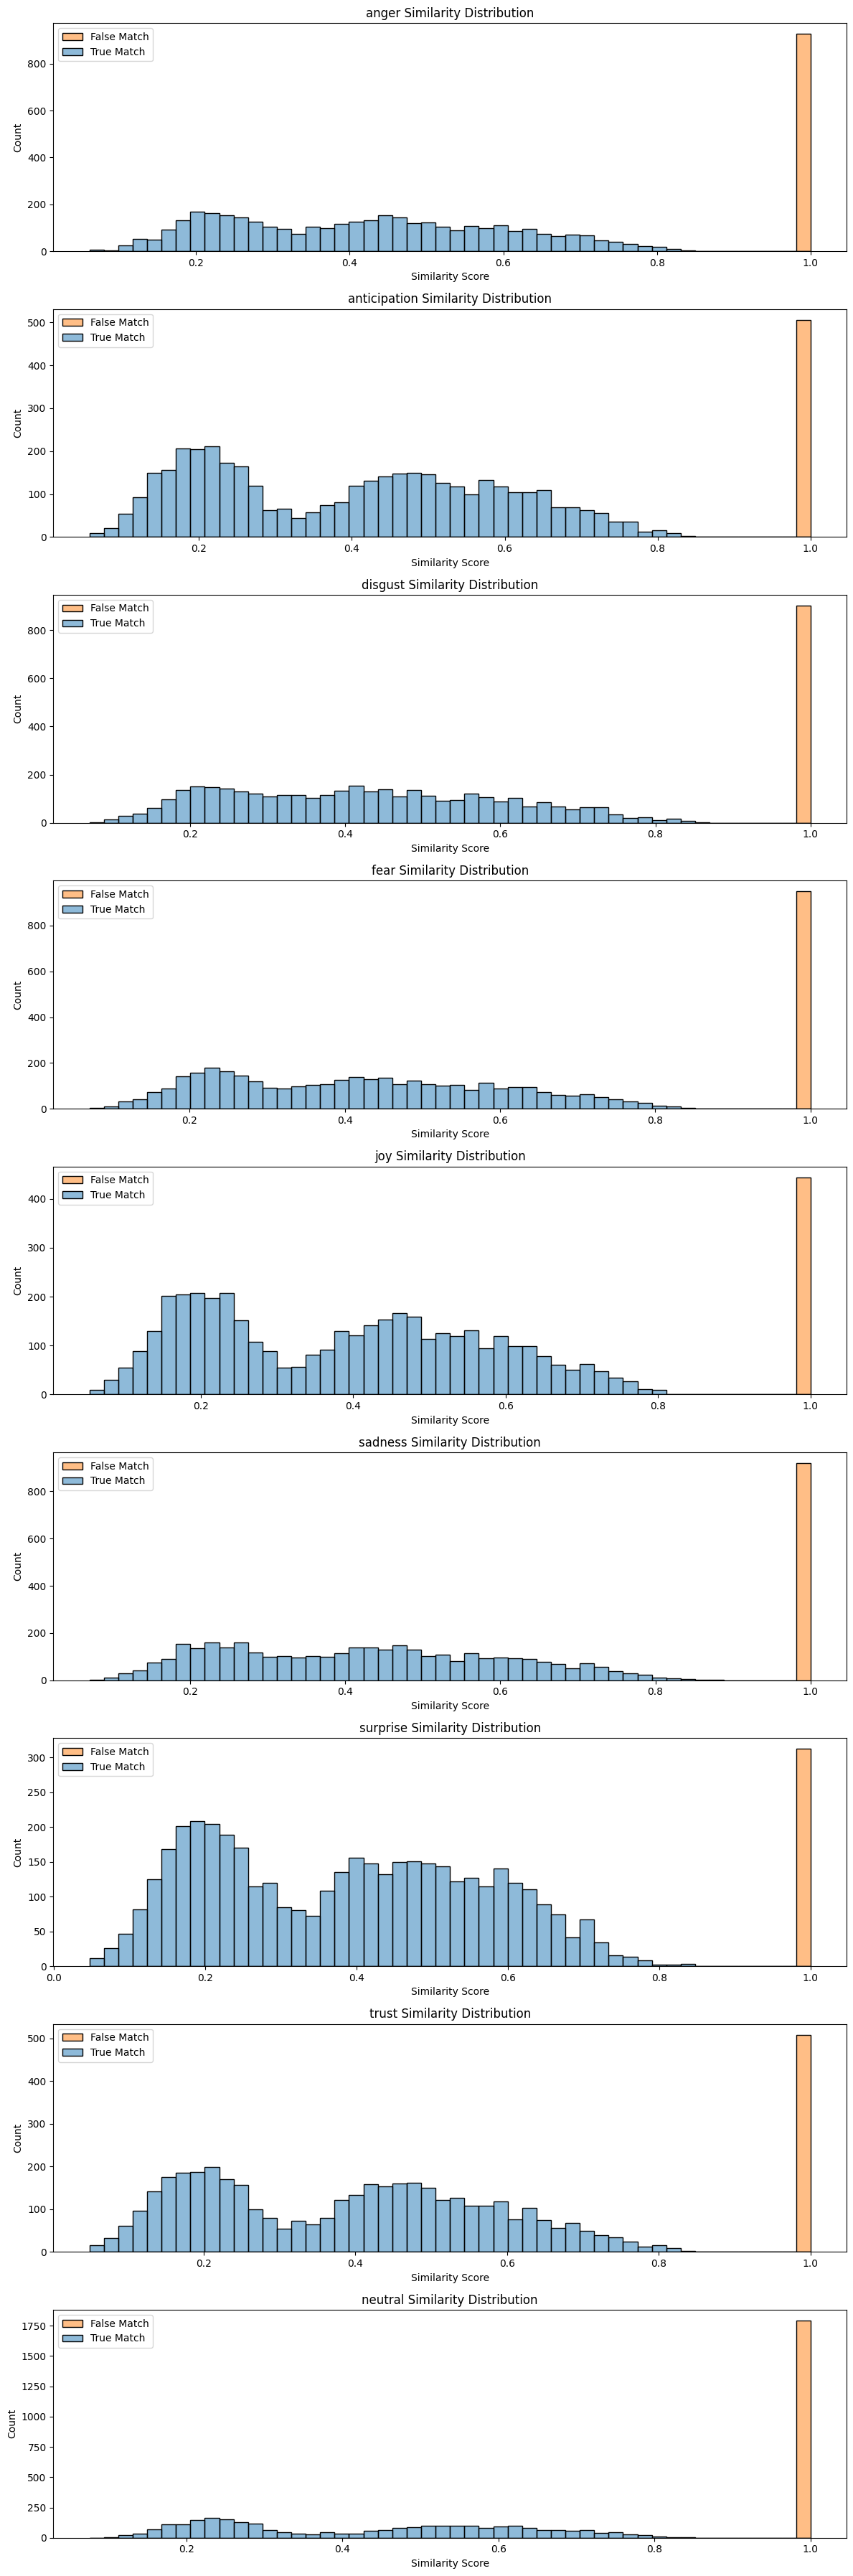


anger:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.417
  Std:  0.177

anticipation:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.397
  Std:  0.189

disgust:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.422
  Std:  0.174

fear:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.417
  Std:  0.176

joy:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.385
  Std:  0.182

sadness:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.420
  Std:  0.175

surprise:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.382
  Std:  0.177

trust:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.384
  Std:  0.184

neutral:
True matches:
  Mean: 1.000
  Std:  0.000
False matches:
  Mean: 0.429
  Std:  0.190
Processing words...


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Results for 'angry':
Raw similarities: {'anger': 1.0, 'anticipation': 0.43848891423736136, 'disgust': 1.0, 'fear': 0.5300193556878877, 'joy': 0.3975992809870266, 'sadness': 0.5285084899858482, 'surprise': 0.5300193556878877, 'trust': 0.3919168848051366, 'neutral': 0.4544541450182371}
Calibrated similarities: {'anger': 3.2977904747565017, 'anticipation': 0.21870906787564517, 'disgust': 3.3202766522006044, 'fear': 0.6404095629144905, 'joy': 0.07166530150538396, 'sadness': 0.6177738798907851, 'surprise': 0.8337751548471911, 'trust': 0.04170578184267957, 'neutral': 0.13503170189819175}


In [125]:
%matplotlib inline
# Plot distributions
plot_emotion_distributions(emotion_distances)
plt.show()

# Print statistics
for emotion, stat in stats.items():
    print(f"\n{emotion}:")
    print("True matches:")
    print(f"  Mean: {stat['true_matches']['mean']:.3f}")
    print(f"  Std:  {stat['true_matches']['std']:.3f}")
    print("False matches:")
    print(f"  Mean: {stat['false_matches']['mean']:.3f}")
    print(f"  Std:  {stat['false_matches']['std']:.3f}")

# Example of using calibration
word = "angry"
results = process_with_calibration(word, calculator, stats, method='zscore')
print(f"\nResults for '{word}':")
print("Raw similarities:", results['raw']['similarities'])
print("Calibrated similarities:", results['calibrated'])

In [119]:
from convokit import Corpus

corpus = Corpus("/Users/Panos/.convokit/downloads/winning-args-corpus")
def get_thread(corpus: Corpus, conv_id: str) -> pd.DataFrame:
    """
    Extracts and structures conversation data from a ConvoKit corpus for a given conversation ID.
    
    Args:
        corpus (Corpus): The ConvoKit corpus containing conversation data.
        conv_id (str): The conversation ID for which to extract the thread.
    
    Returns:
        pd.DataFrame: A DataFrame containing utterance ID, speaker, reply-to relationship, timestamp, and text for the conversation thread.
    """
    root_conversation = corpus.conversations[conv_id]

    # Loop through each utterance and collect necessary information
    thread_data = []
    for utt in root_conversation.iter_utterances():
        try:
            thread_data.append({
                'utterance_id': utt.id,
                'speaker'     : utt.speaker.id,
                'reply_to'    : utt.reply_to if utt.reply_to is not None
                else utt.id,
                'timestamp'   : utt.timestamp if utt.timestamp is not None
                else 0,
                'text'        : utt.text,
                'success'     : utt.meta['success'] if utt.meta['success']
                                                       is not None else -1
            })
        except KeyError:
            continue

    # Create a DataFrame from the collected data and sort it
    df = pd.DataFrame(thread_data)
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    return df


# Get conversation IDs
convos = [i.id for i in corpus.iter_conversations()]

# Extract thread data for the first conversation
thread_df = get_thread(corpus, convos[0])
text = thread_df["text"][0]


Processing words...


100%|██████████| 264/264 [00:20<00:00, 12.93it/s]



Emotion Statistics:
--------------------------------------------------

ANGER:
Count: 156
Mean: 0.395 (±0.168)
Range: [0.015, 1.000]
Quartiles: 0.316 | 0.391 | 0.452

Top matches:
1. disagree -> disagree (1.000)
2. opposed -> opposed (1.000)
3. argument -> argument (1.000)
4. spurred -> restrain (0.818)
5. arguments -> argument (0.798)

ANTICIPATION:
Count: 156
Mean: 0.411 (±0.162)
Range: [0.014, 1.000]
Quartiles: 0.336 | 0.425 | 0.480

Top matches:
1. coming -> coming (1.000)
2. think -> think (1.000)
3. intended -> intended (1.000)
4. spurred -> withstand (0.770)
5. disagree -> withstand (0.760)

DISGUST:
Count: 156
Mean: 0.377 (±0.146)
Range: [0.015, 1.000]
Quartiles: 0.311 | 0.383 | 0.441

Top matches:
1. unnatural -> unnatural (1.000)
2. disagree -> contentious (0.805)
3. spurred -> displeasure (0.800)
4. debating -> contentious (0.793)
5. creations -> plight (0.732)

FEAR:
Count: 156
Mean: 0.388 (±0.151)
Range: [0.015, 1.000]
Quartiles: 0.323 | 0.388 | 0.454

Top matches:
1. opp

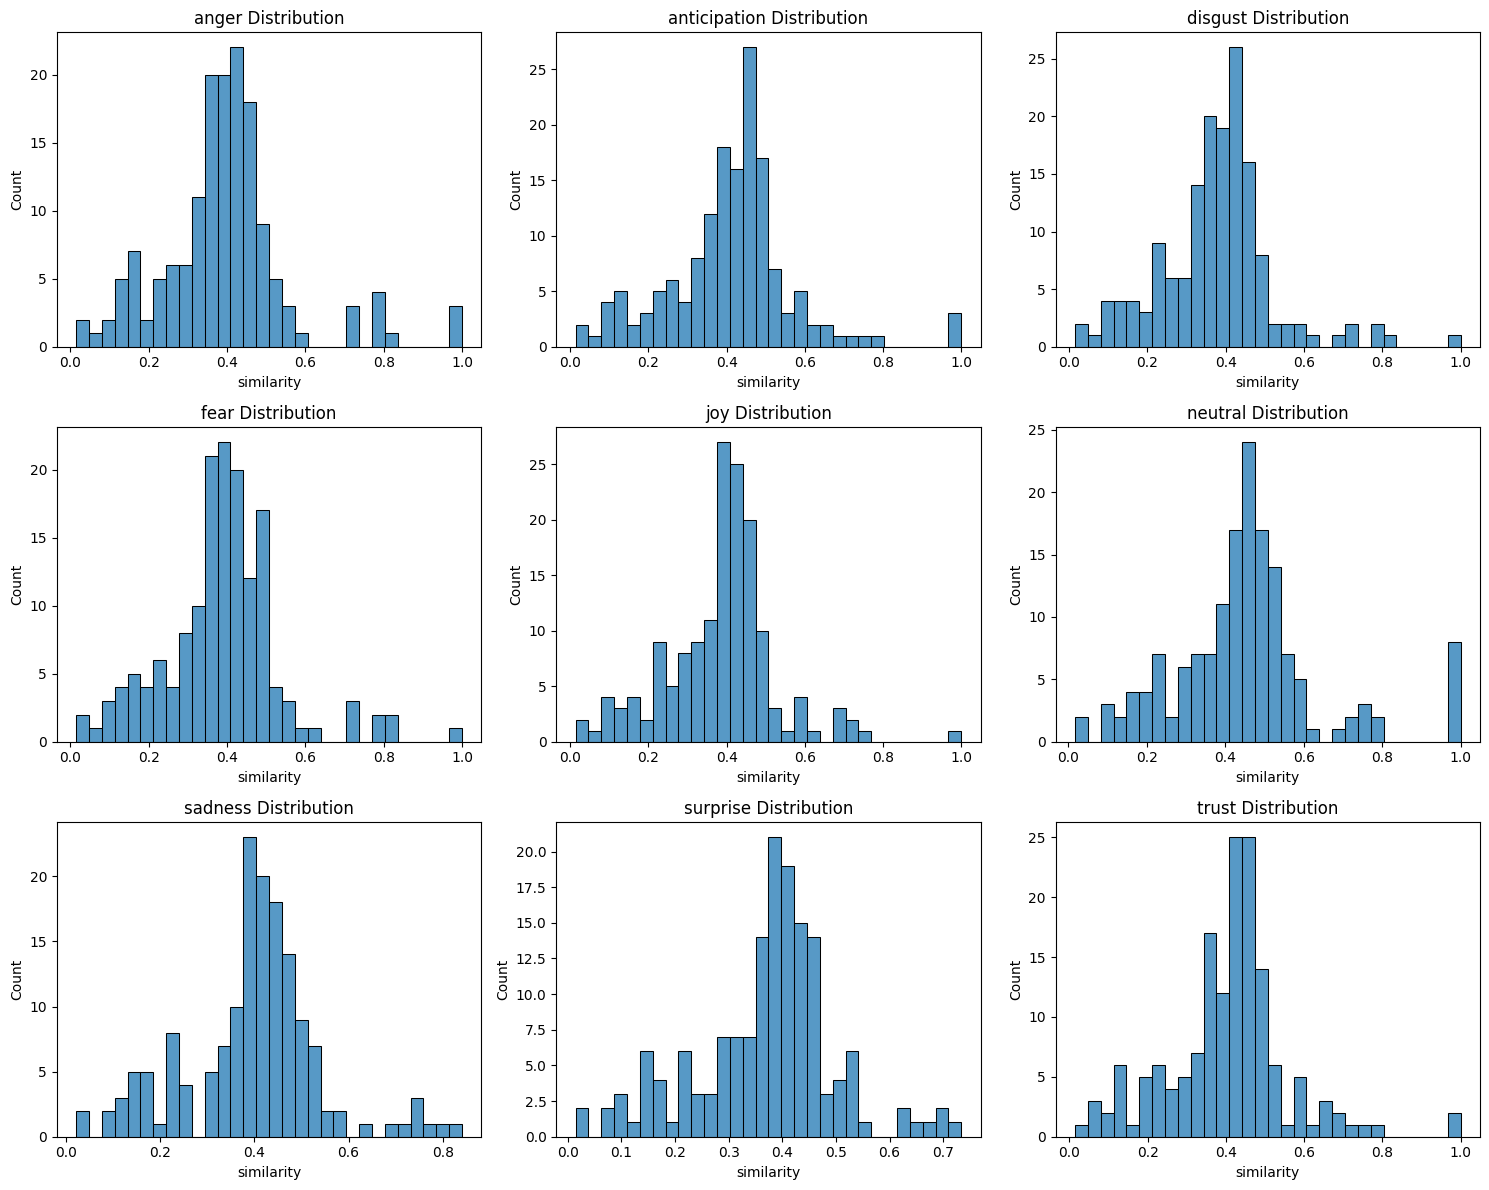

anger: mean=0.395, std=0.168
anticipation: mean=0.411, std=0.162
disgust: mean=0.377, std=0.146
fear: mean=0.388, std=0.151
joy: mean=0.386, std=0.142
sadness: mean=0.396, std=0.144
surprise: mean=0.369, std=0.130
trust: mean=0.405, std=0.157
neutral: mean=0.453, std=0.193


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def analyze_emotion_distances(emotion_distances_results):
    """
    Analyze emotion distances for any input text.
    
    Args:
        emotion_distances_results: Dictionary of results from EmotionDistanceCalculator
        
    Returns:
        DataFrame with statistics for each emotion
    """
    # Collect all distances per emotion
    all_stats = []
    
    for word, word_results in emotion_distances_results.items():
        for emotion, similarity in word_results['similarities'].items():
            if not np.isnan(similarity):
                all_stats.append({
                    'word': word,
                    'emotion': emotion,
                    'similarity': similarity,
                    'nearest_word': word_results['nearest_words'][emotion]
                })
    
    return pd.DataFrame(all_stats)

def calculate_emotion_statistics(results_df):
    """
    Calculate statistics for each emotion.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        
    Returns:
        Dictionary of statistics per emotion
    """
    stats = {}
    
    for emotion in results_df['emotion'].unique():
        emotion_data = results_df[results_df['emotion'] == emotion]['similarity']
        
        stats[emotion] = {
            'count': len(emotion_data),
            'mean': emotion_data.mean(),
            'std': emotion_data.std(),
            'min': emotion_data.min(),
            'max': emotion_data.max(),
            'median': emotion_data.median(),
            'q25': emotion_data.quantile(0.25),
            'q75': emotion_data.quantile(0.75)
        }
    
    return stats

def plot_emotion_analysis(results_df):
    """
    Create various plots for emotion analysis.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        
    Returns:
        Dictionary of figures
    """
    figures = {}
    
    # # 1. Distribution plot for all emotions
    # fig_dist, ax_dist = plt.subplots(figsize=(12, 6))
    # sns.violinplot(data=results_df, x='emotion', y='similarity', ax=ax_dist)
    # ax_dist.set_xticklabels(ax_dist.get_xticklabels(), rotation=45)
    # ax_dist.set_title('Emotion Similarity Distributions')
    # figures['distributions'] = fig_dist
    
    # 2. Histogram grid for each emotion
    n_emotions = len(results_df['emotion'].unique())
    n_cols = 3
    n_rows = (n_emotions + n_cols - 1) // n_cols
    
    fig_hist, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for idx, emotion in enumerate(sorted(results_df['emotion'].unique())):
        emotion_data = results_df[results_df['emotion'] == emotion]
        sns.histplot(data=emotion_data, x='similarity', bins=30, ax=axes[idx])
        axes[idx].set_title(f'{emotion} Distribution')
        
    # Hide empty subplots
    for idx in range(n_emotions, len(axes)):
        axes[idx].set_visible(False)
        
    plt.tight_layout()
    figures['histograms'] = fig_hist
    
    # # 3. Box plot
    # fig_box, ax_box = plt.subplots(figsize=(12, 6))
    # sns.boxplot(data=results_df, x='emotion', y='similarity', ax=ax_box)
    # ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=45)
    # ax_box.set_title('Emotion Similarity Distributions (Box Plot)')
    # figures['boxplot'] = fig_box
    
    return figures

def get_top_matches(results_df, n=10):
    """
    Get top N matches for each emotion.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        n: Number of top matches to return
        
    Returns:
        Dictionary of top matches per emotion
    """
    top_matches = {}
    
    for emotion in results_df['emotion'].unique():
        emotion_data = results_df[results_df['emotion'] == emotion].nlargest(n, 'similarity')
        top_matches[emotion] = emotion_data[['word', 'similarity', 'nearest_word']].to_dict('records')
    
    return top_matches

def print_emotion_analysis(stats, top_matches):
    """
    Print detailed analysis results.
    
    Args:
        stats: Dictionary from calculate_emotion_statistics
        top_matches: Dictionary from get_top_matches
    """
    print("\nEmotion Statistics:")
    print("-" * 50)
    
    for emotion, stat in stats.items():
        print(f"\n{emotion.upper()}:")
        print(f"Count: {stat['count']}")
        print(f"Mean: {stat['mean']:.3f} (±{stat['std']:.3f})")
        print(f"Range: [{stat['min']:.3f}, {stat['max']:.3f}]")
        print(f"Quartiles: {stat['q25']:.3f} | {stat['median']:.3f} | {stat['q75']:.3f}")
        
        print("\nTop matches:")
        for idx, match in enumerate(top_matches[emotion][:5], 1):
            print(f"{idx}. {match['word']} -> {match['nearest_word']} ({match['similarity']:.3f})")

results = calculator.process_batch(text.split(" "))

# Results from EmotionDistanceCalculator
results_df = analyze_emotion_distances(results)

# Calculate statistics
stats = calculate_emotion_statistics(results_df)

# Get top matches
top_matches = get_top_matches(results_df)

# Print analysis
print_emotion_analysis(stats, top_matches)

# Create plots
figures = plot_emotion_analysis(results_df)
plt.show()

# Access specific statistics
for emotion, stat in stats.items():
    print(f"{emotion}: mean={stat['mean']:.3f}, std={stat['std']:.3f}")

In [130]:
results

{'I': {'distances': {'anger': 0.6410638291876202,
   'anticipation': 0.6278106073582448,
   'disgust': 0.6513139392175866,
   'fear': 0.6386943948894501,
   'joy': 0.6269778200677414,
   'sadness': 0.6128968039878582,
   'surprise': 0.6128968039878582,
   'trust': 0.6269778200677414,
   'neutral': 0.5972414443625667},
  'similarities': {'anger': 0.35893617081237983,
   'anticipation': 0.37218939264175527,
   'disgust': 0.3486860607824133,
   'fear': 0.36130560511054993,
   'joy': 0.3730221799322586,
   'sadness': 0.38710319601214177,
   'surprise': 0.38710319601214177,
   'trust': 0.3730221799322586,
   'neutral': 0.40275855563743335},
  'nearest_words': {'anger': 'stone',
   'anticipation': 'thought',
   'disgust': 'hell',
   'fear': 'worse',
   'joy': 'kind',
   'sadness': 'leave',
   'surprise': 'leave',
   'trust': 'kind',
   'neutral': 'time'},
  'raw_similarities': {'anger': 0.8975389296518349,
   'anticipation': 0.901164756573811,
   'disgust': 0.8946416699086612,
   'fear': 0.8